In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.formula.api as sm
import scipy, scipy.stats
import math
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("LGD_DATA.csv")

In [3]:
df.columns=['Acc_no','Age','Years_of_experience','Number_of_vehicles','Gender','Married','Loss_in_thousands']
df.columns

Index(['Acc_no', 'Age', 'Years_of_experience', 'Number_of_vehicles', 'Gender',
       'Married', 'Loss_in_thousands'],
      dtype='object')

In [4]:
df.head()

,Acc_no,Age,Years_of_experience,Number_of_vehicles,Gender,Married,Loss_in_thousands
0,150024,24,5,1,M,Married,203.319595
1,144880,31,10,1,F,Single,402.197302
2,133742,56,37,1,M,Married,553.132096
3,151282,52,31,1,F,Married,292.430579
4,174407,20,3,1,M,Single,246.540576


In [5]:
#dummy variables for categorical variables
dummyvar1=pd.get_dummies(df.Gender,drop_first=True)
dummyvar2=pd.get_dummies(df.Married,drop_first=True)
df_new=pd.concat([df.drop(['Married','Gender'],axis=1),dummyvar1,dummyvar2],axis=1)
#to normalise the variable which is right skewed
df_new['Log_of_loss']=list(map(math.log,df.Loss_in_thousands))
df_new.head()

,Acc_no,Age,Years_of_experience,Number_of_vehicles,Loss_in_thousands,M,Single,Log_of_loss
0,150024,24,5,1,203.319595,1,0,5.314779
1,144880,31,10,1,402.197302,0,1,5.996943
2,133742,56,37,1,553.132096,1,0,6.315597
3,151282,52,31,1,292.430579,0,0,5.678227
4,174407,20,3,1,246.540576,1,1,5.507527


In [6]:
from sklearn.model_selection import train_test_split
x=df_new[['Age','Number_of_vehicles','M','Single']]
y=df_new.Log_of_loss
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=1)

In [7]:
#Building RF model
from sklearn.ensemble import RandomForestRegressor
Rfr=RandomForestRegressor(n_estimators=300, max_depth=2, criterion='mae',bootstrap=True, random_state=10)

In [8]:
Rfr.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300,
                      n_jobs=None, oob_score=False, random_state=10, verbose=0,
                      warm_start=False)

In [9]:
Rfr.feature_importances_

array([7.77893555e-01, 0.00000000e+00, 4.05159142e-04, 2.21701286e-01])

In [10]:
#performance on training data
y_train_pred=Rfr.predict(x_train)
from sklearn import metrics
print('R2 Score: ',metrics.r2_score(y_train,y_train_pred))
print('MAPE is ',abs((y_train-y_train_pred)/y_train).mean()*100)

R2 Score:  0.38126358408653893
MAPE is  8.200468482547727


In [11]:
#performance on testing data
y_pred=Rfr.predict(x_test)
print('R2 Score: ',metrics.r2_score(y_test,y_pred))
print('MAPE is ',abs((y_test-y_pred)/y_test).mean()*100)

R2 Score:  0.39183173007844085
MAPE is  8.045254227524055


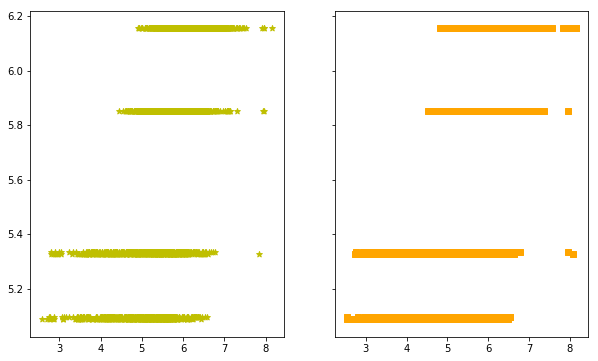

In [12]:
fig, ax=plt.subplots(1,2, sharey=True,figsize=(10,6))
ax[0].scatter(y_test,y_pred,marker='*',c='y')
ax[1].scatter(y_train,y_train_pred,marker='s',c='orange')

-----

5-fold Cross validation for parameter tuning to improve result

In [13]:
from sklearn.model_selection import cross_val_score
depth_=[]
for i in range(2,7):
    Rfr_=RandomForestRegressor(n_estimators=300, max_depth=i, criterion='mae',bootstrap=True, random_state=10)
    score_=cross_val_score(estimator=Rfr_,X=x_train,y=y_train,cv=5)
    depth_.append((i,score_.mean()))
print(depth_)

[(2, 0.3797927496074918), (3, 0.40560527323367984), (4, 0.4245060373839246), (5, 0.42276812774199984), (6, 0.41989199899707685)]


In [13]:
#max depth = 4 is best parameter
Rfr_new=RandomForestRegressor(n_estimators=300, max_depth=4, criterion='mae',bootstrap=True, random_state=10)
Rfr_new.fit(x_train,y_train)
Rfr_new.feature_importances_

array([0.71289202, 0.00412316, 0.10710514, 0.17587968])

In [14]:
#performance on training data
Y_train_pred=Rfr_new.predict(x_train)
from sklearn import metrics
print('R2 Score: ',metrics.r2_score(y_train,Y_train_pred))
print('MAPE is ',abs((y_train-Y_train_pred)/y_train).mean()*100)

R2 Score:  0.4302782824263265
MAPE is  7.791985950257355


In [15]:
#performance on testing data
Y_pred=Rfr_new.predict(x_test)
print('R2 Score: ',metrics.r2_score(y_test,Y_pred))
print('MAPE is ',abs((y_test-Y_pred)/y_test).mean()*100)

R2 Score:  0.4315319609391588
MAPE is  7.678373612262043


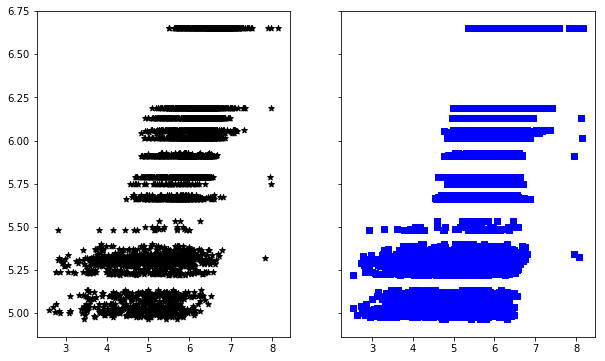

In [16]:
fig, ax=plt.subplots(1,2, sharey=True,figsize=(10,6))
ax[0].scatter(y_test,Y_pred,marker='*',c='black')
ax[1].scatter(y_train,Y_train_pred,marker='s',c='blue')